In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

In [2]:
import pandas as pd
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cols=['tweetid', 'entity', 'target', 'content']

df_train  = pd.read_csv("twitter_training.csv",names=cols)
df_test  = pd.read_csv("twitter_validation.csv",names=cols)

In [3]:
df_train.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']
df_test.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']

In [4]:
df_train.head()

,Tweet ID,Entity,Sentiment,Tweet Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Data Preprocessing

In [5]:
df_train.drop(columns=['Tweet ID'], inplace=True)
df_test.drop(columns=['Tweet ID'], inplace=True)

In [6]:
df_train.isnull().sum()
df_test.isnull().sum()

Entity           0
Sentiment        0
Tweet Content    0
dtype: int64

In [7]:
df_train.duplicated().sum()
df_test.duplicated().sum()

0

In [8]:
twitter_sentiments = pd.concat([df_train,df_test],ignore_index=True)
twitter_sentiments.shape
twitter_sentiments.duplicated().sum()

4138

In [9]:
twitter_sentiments.drop_duplicates(inplace=True)

print("Number of duplicates in the twitter_sentiments:", twitter_sentiments.duplicated().sum())
twitter_sentiments.shape

Number of duplicates in the twitter_sentiments: 0


(71544, 3)

In [10]:
# Replace NaN values with an empty string
twitter_sentiments['Tweet Content'] = twitter_sentiments['Tweet Content'].fillna('')

# Ensure all values are strings
twitter_sentiments['Tweet Content'] = twitter_sentiments['Tweet Content'].astype(str)

In [11]:
twitter_sentiments['Tweet Content Length'] = twitter_sentiments['Tweet Content'].apply(len)
twitter_sentiments.head()
twitter_sentiments.iloc[:5]

,Entity,Sentiment,Tweet Content,Tweet Content Length
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,53
1,Borderlands,Positive,I am coming to the borders and I will kill you...,51
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,50
3,Borderlands,Positive,im coming on borderlands and i will murder you...,51
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57


In [12]:
df_train['Tweet Content'] = df_train['Tweet Content'].fillna('')
df_test['Tweet Content'] = df_test['Tweet Content'].fillna('')

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ramsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
def remove_urls(text: str) -> str:
    return re.sub(r'https*\S+', ' ', text)

In [15]:
def remove_mentions_and_hashtags(text: str) -> str:
    return re.sub(r'[@#]\S+', ' ', text)

In [16]:
def remove_html_tags(text: str) -> str:
    return re.sub('<.*?>', '', text)

In [17]:
def expand_contractions(text: str) -> str:
    contractions = {"don't": 'do not', "can't": 'cannot'}
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text

In [18]:
def remove_punctuation(text: str) -> str:
    return re.sub('[%s]' % re.escape(string.punctuation), '', text)


In [19]:
def remove_punctuation(text: str) -> str:
    return re.sub('[%s]' % re.escape(string.punctuation), '', text)


In [20]:
def remove_extra_whitespaces(text: str) -> str:
    return re.sub('\s{2,}', ' ', text)

In [21]:
def remove_special_characters_and_emojis(text: str) -> str:
    special_char_pattern = r'[^a-zA-Z0-9\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]'

    return re.sub(special_char_pattern, '', text)


In [22]:
def tokenize_and_lemmatize(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_set]
    return ' '.join(lemmatized_words)

In [23]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = remove_special_characters_and_emojis(text)
    text = remove_urls(text)
    text = remove_mentions_and_hashtags(text)
    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_extra_whitespaces(text)
    text = tokenize_and_lemmatize(text)
    return text

In [24]:
df_train['cleaned_tweet'] = df_train['Tweet Content'].apply(clean_text)
df_test['cleaned_tweet'] = df_test['Tweet Content'].apply(clean_text)

In [25]:
df_train['Sentiment'] = df_train['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_train['Sentiment'].value_counts()}")
df_test['Sentiment'] = df_test['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_test['Sentiment'].value_counts()}")

Sentiment value count: 
 Neutral     31308
Negative    22542
Positive    20832
Name: Sentiment, dtype: int64
Sentiment value count: 
 Neutral     457
Positive    277
Negative    266
Name: Sentiment, dtype: int64


In [26]:
label_encoder = LabelEncoder()
df_train['encoded_sentiment'] = label_encoder.fit_transform(df_train['Sentiment'])
df_test['encoded_sentiment'] = label_encoder.transform(df_test['Sentiment'])

In [27]:
twitter_sentiments = pd.concat([df_train['cleaned_tweet'], df_test['cleaned_tweet']])

tokenized_tweets = [tweet.split() for tweet in twitter_sentiments]

w2v_model = Word2Vec(tokenized_tweets, vector_size=100, window=5, min_count=1, sample=1e-3, epochs=10)

##  Train Word2Vec model

In [28]:
twitter_sentiments = pd.concat([df_train['cleaned_tweet'], df_test['cleaned_tweet']])

tokenized_tweets = [tweet.split() for tweet in twitter_sentiments]

w2v_model = Word2Vec(tokenized_tweets, vector_size=100, window=5, min_count=1, sample=1e-3, epochs=10)

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(twitter_sentiments)

train_sequences = tokenizer.texts_to_sequences(df_train['cleaned_tweet'])
test_sequences = tokenizer.texts_to_sequences(df_test['cleaned_tweet'])

X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

y_train = df_train['encoded_sentiment']
y_test = df_test['encoded_sentiment']

## Train LSTM model

In [30]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax')) # 3 units for 'Positive', 'Negative', 'Neutral'

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 250s 523ms/step - accuracy: 0.5940 - loss: 0.8432 - val_accuracy: 0.5489 - val_loss: 1.1624
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 256s 548ms/step - accuracy: 0.8804 - loss: 0.3016 - val_accuracy: 0.5280 - val_loss: 1.6591
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 305s 653ms/step - accuracy: 0.9289 - loss: 0.1807 - val_accuracy: 0.5233 - val_loss: 1.9242
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 292s 625ms/step - accuracy: 0.9401 - loss: 0.1436 - val_accuracy: 0.5221 - val_loss: 2.1560
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 325s 695ms/step - accuracy: 0.9506 - loss: 0.1173 - val_accuracy: 0.5133 - val_loss: 2.3429
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 313s 670ms/step - accuracy: 0.9536 - loss: 0.1104 - val_accuracy: 0.5011 - val_loss: 2.6819
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 312s 668ms/step - accuracy: 0.9581 - loss: 0.0985 - val_accuracy: 0.5062 - val_loss: 2.8041
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 282s 603ms/step - accuracy: 0.9599 -

In [32]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8774 - loss: 0.7585
Test Loss: 0.8611305356025696
Test Accuracy: 0.8700000047683716


## Confusion Matrix for LSTM Results

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


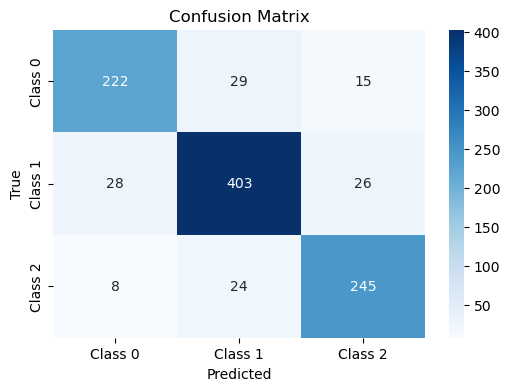

In [33]:
import numpy as np
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Train SVC model

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(df_train['cleaned_tweet'])
X_test_tfidf = vectorizer.transform(df_test['cleaned_tweet'])

y_train = df_train['encoded_sentiment']
y_test = df_test['encoded_sentiment']

In [35]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))


X_train_tfidf = vectorizer.fit_transform(df_train['cleaned_tweet'])
X_test_tfidf = vectorizer.transform(df_test['cleaned_tweet'])

y_train = df_train['encoded_sentiment']
y_test = df_test['encoded_sentiment']

In [36]:
svm_model = SVC(kernel='linear', C=1, random_state=42)

svm_model.fit(X_train_tfidf, y_train)

SVC(C=1, kernel='linear', random_state=42)

## Confusion Matrix for SVC Results

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88       266
           1       0.91      0.88      0.90       457
           2       0.90      0.87      0.88       277

    accuracy                           0.89      1000
   macro avg       0.88      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



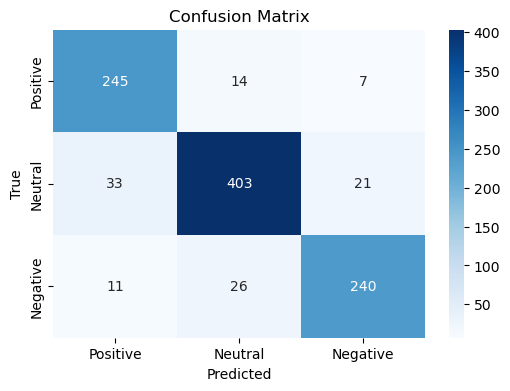

In [37]:
y_pred = svm_model.predict(X_test_tfidf)

print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Positive', 'Neutral', 'Negative'], 
            yticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()